# 图像文件格式的优缺点
在处理显微镜图像数据时，存在许多文件格式。大多数显微镜供应商都有专有的图像文件格式，图像分析软件供应商提供自定义和部分开放的文件格式。传统文件格式也存在，并得到常见Python库的支持。对于通用图像存储，只有少数图像文件格式如[TIF](https://en.wikipedia.org/wiki/TIFF)可以被推荐。此外，应避免使用[JPEG](https://en.wikipedia.org/wiki/JPEG)等格式以保持图像数据的完整性。在本笔记本中，我们将通过将显微镜图像重新保存为这些格式，然后重新加载图像并比较保存前后的图像来测试一些文件格式。

另请参阅
* [ImageIO](https://github.com/imageio/imageio)
* [AICSImageIO](https://github.com/AllenCellModeling/aicsimageio)
* [python-bioformats](https://github.com/CellProfiler/python-bioformats)
* [Moore et al. Nat Methods (2021) "OME-NGFF: a next-generation file format for expanding bioimaging data-access strategies"](https://www.nature.com/articles/s41592-021-01326-w)

In [1]:
from skimage.data import cells3d
from skimage.io import imread, imsave
import pyclesperanto_prototype as cle
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
import warnings

作为示例图像，我们使用scikit-image提供的[Cells 3D](https://scikit-image.org/docs/dev/api/skimage.data.html#skimage.data.cells3d)示例图像，该图像由Allen细胞科学研究所提供。它是一个无符号16位整数图像。在第一次尝试中，我们将只选择单个通道和平面。

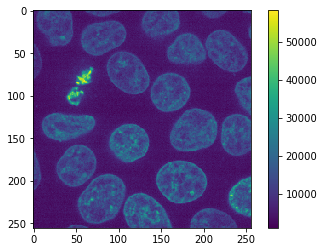

In [2]:
original_image = cells3d()[30, 1]
cle.imshow(original_image, colorbar=True)

## 为什么应该避免使用JPEG
JPEG文件格式，至少在许多程序的默认设置下，是一种有损文件格式。这意味着在保存图像时会丢失信息。

In [3]:
imsave("temp.jpg", original_image)

Lossy conversion from uint16 to uint8. Losing 8 bits of resolution. Convert image to uint8 prior to saving to suppress this warning.


上面的警告证实了这一点。此外，当我们重新加载图像时，我们可以在颜色条中看到强度范围现在不同了。

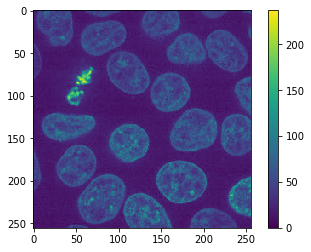

In [4]:
jpg_image = imread("temp.jpg")

cle.imshow(jpg_image, colorbar=True)

此外，如果我们放大，我们可以看到两种典型的JPEG伪影。
* 图像被去噪。
* 我们看到补丁，例如8x8像素大小，以及朝不同方向的条纹。

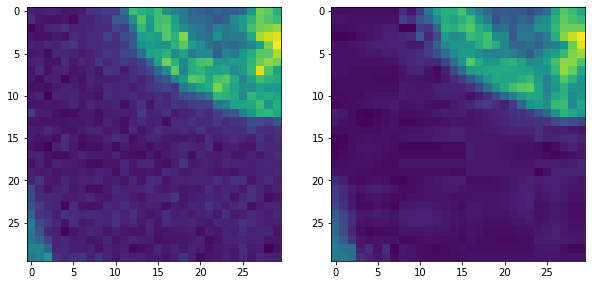

In [5]:
fix, axs = plt.subplots(1,2,figsize=(10,10))

cle.imshow(original_image[140:170, 0:30], plot=axs[0])
cle.imshow(jpg_image[140:170, 0:30], plot=axs[1])

为了定量研究这些错误，并测试多种文件格式，我们编写一个简短的函数，该函数保存并重新加载图像，并输出一个包含一些测量结果的表格，

In [6]:
def resave_image_statistics(original_image):
    """以多种格式保存并重新加载图像，并返回包含图像统计信息的表格。"""

    # 准备表格
    stats = {
        "ending":[],
        "data_type":[],
        "shape":[],
        "size":[],
        "min":[],
        "max":[],
        "mean":[],
        "standard_deviation":[],
        "mean_squared_error":[],
    }
    
    # 遍历不同的文件扩展名
    endings = [None, "tif","png","mhd","mha","jpg","gif","bmp"]
    for ending in endings:
        try:
            if ending is None:
                # 使用原始图像作为第一个测试
                reloaded_image = original_image
                size = np.NaN
            else:
                # 保存并重新加载图像
                filename = "temp." + ending
                imsave(filename, original_image)

                reloaded_image = imread(filename)
                size = os.path.getsize(filename)
            
            # 确定统计信息
            stats["ending"].append(ending)
            stats["data_type"].append(reloaded_image.dtype)
            stats["shape"].append(reloaded_image.shape)
            stats["size"].append(size)
            stats["min"].append(np.min(reloaded_image))
            stats["max"].append(np.max(reloaded_image.astype(float)))
            stats["mean"].append(np.mean(reloaded_image))
            stats["standard_deviation"].append(np.std(reloaded_image))

            stats["mean_squared_error"].append(np.mean((original_image - reloaded_image)**2))

        except ValueError:
            # 某些格式不受支持
            warnings.warn("不支持的文件格式: " + ending)
            pass

    return pd.DataFrame(stats)

接下来，我们将该函数应用于2D图像切片。

In [7]:
resave_image_statistics(cells3d()[30, 1])

Lossy conversion from uint16 to uint8. Losing 8 bits of resolution. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from uint16 to uint8. Losing 8 bits of resolution. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from uint16 to uint8. Losing 8 bits of resolution. Convert image to uint8 prior to saving to suppress this warning.


ending data_type       shape      size   min      max         mean  \
0   None    uint16  (256, 256)       NaN  1091  58327.0  9346.115417   
1    tif    uint16  (256, 256)  131328.0  1091  58327.0  9346.115417   
2    png    uint16  (256, 256)  107470.0  1091  58327.0  9346.115417   
3    mhd    uint16  (256, 256)     281.0  1091  58327.0  9346.115417   
4    mha    uint16  (256, 256)  131350.0  1091  58327.0  9346.115417   
5    jpg     uint8  (256, 256)    9271.0     0    237.0    36.005875   
6    gif     uint8  (256, 256)   58225.0     4    227.0    36.014725   
7    bmp     uint8  (256, 256)   66614.0     4    227.0    36.014725   

   standard_deviation  mean_squared_error  
0         6139.322637            0.000000  
1         6139.322637            0.000000  
2         6139.322637            0.000000  
3         6139.322637            0.000000  
4         6139.322637            0.000000  
5           23.824527        32596.059555  
6           23.978329        32236.271164  
7           23.978329        32236.271164

## 保存3D图像
我们可以使用相同的函数来测试哪些文件格式支持3D图像。

In [8]:
resave_image_statistics(cells3d()[30])

File format not supported: png
File format not supported: mhd
File format not supported: mha
File format not supported: jpg
File format not supported: gif
File format not supported: bmp


ending data_type          shape      size  min      max         mean  \
0   None    uint16  (2, 256, 256)       NaN  277  58327.0  5925.968422   
1    tif    uint16  (2, 256, 256)  262566.0  277  58327.0  5925.968422   

   standard_deviation  mean_squared_error  
0         5711.584119                 0.0  
1         5711.584119                 0.0

## 保存4D图像
`cells3d`数据集实际上是一个4D数据集。它还包含通道。因此，我们也可以用它来测试保存和重新加载4D数据。

In [9]:
resave_image_statistics(cells3d())

File format not supported: png
File format not supported: mhd
File format not supported: mha
File format not supported: jpg
File format not supported: gif
File format not supported: bmp


ending data_type              shape        size  min      max        mean  \
0   None    uint16  (60, 2, 256, 256)         NaN    0  65535.0  4837.14054   
1    tif    uint16  (60, 2, 256, 256)  15748650.0    0  65535.0  4837.14054   

   standard_deviation  mean_squared_error  
0         3985.348828                 0.0  
1         3985.348828                 0.0

因此，可以推荐TIF文件格式。它也与其他软件如[ImageJ](https://imagej.net)和[Fiji](https://fiji.sc)兼容。

## 练习
确定'ico'和'raw'文件格式是否受支持。